# Q-Learning in Market Taking

## Data Input and preprocessing (Compress data)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



def preprocess(data,train):
    data = data.iloc[:, :3]
    data['mid'] = (data.iloc[:, 1] + data.iloc[:, 2]) / 2
    data = data.dropna(axis=0)
    data['T+1 bidPrice'] =  data['bidPrice'].shift(-1)
    data['T+1 offerPrice'] = data['offerPrice'].shift(-1)
    data['state'] = 0
    train_data = data.iloc[:3000]
    #Calculate max and min state from trained states
    midmax = max(train_data['mid'])
    midmin = min(train_data['mid'])
    train_data['state'] = round((train_data['mid'] - midmin)/0.1)
    min_state = min(train_data['state'])
    max_state = max(train_data['state'])
    #Use all dataset if it is not training
    if not train:
        train_data = data
    if train:
        train_data['state'] = max(np.unique(train_data['state'])) - train_data['state']
    else:
        train_data['state'] = round((train_data['mid'] - midmin)/0.1)
        train_data['state'] = max_state - train_data['state']

    num_state = int(max(np.unique(train_data['state'])))+1
    
    if not train:
        for i in range(len(train_data)):
            if train_data.iloc[i,-1]> max_state:
                train_data.iloc[i,-1] = max_state
            if train_data.iloc[i,-1] < min_state:
                train_data.iloc[i,-1]= min_state
    train_data['prev state'] = train_data['state'].shift(1)
    # train = data[(data['next state'] != data['state'])]
    train = train_data[(train_data['prev state'] != train_data['state'])]
    train = train.append(train_data.iloc[-1,:]) # add last row for clearing purpose
    return train, num_state, midmin, midmax


## Setting State space, Action Space

In [2]:
def set_space(num_state):
    ParamSpace = {
        'A_space': np.array([-1, 0, 1]),
        'H_space': np.array([-1,0,1]),
        'r_space': np.array([i for i in range(num_state)])
    }
    return ParamSpace

## Epsilon-greedy algorithm

In [3]:
def chooseAction(state):
    rand = np.random.rand()
    if (rand < epsilon):
        act = np.random.choice([-1, 0, 1], 1)[0]
    else:
        temp = Q_table[state]
        idx = np.argmax(temp)
        act = [-1, 0, 1][idx]
    return act

## Learn as a taker to calculate reward 

In [4]:
class TakerGame:
    def __init__(self, data):
        self.data = data
        self.action_space = np.array([-1, 0, 1])
        self.observation = (int(self.data['state'].iloc[0]),0)
        self.time = 0
        self.position = 0
        self.unr_pnl = 0

    def reset(self, init_position=0):
        self.position = init_position
        self.observation = (int(self.data['state'].iloc[0]),self.position)
        self.unr_pnl = 0
        self.time = 0
        return self.observation

    def step(self, action):
        instant_pnl = 0
        reward = 0
        kappa = 0.01
        tomorrow_bid = self.data.iloc[self.time, 1]
        tomorrow_ask = self.data.iloc[self.time, 2]
        if self.position == 0:
            # either long or short will not have realized pnl
            if action == 1:
                self.unr_pnl = -tomorrow_ask
            elif action == -1:
                self.unr_pnl = tomorrow_bid
            instant_pnl = 0
                
        elif self.position == 1:
            # short will cause pnl, long will do nothing, flat will cause pnl
            if action == 0:
                instant_pnl = tomorrow_bid + self.unr_pnl
                self.unr_pnl = 0
            elif action == -1:
                instant_pnl = tomorrow_bid + self.unr_pnl
                self.unr_pnl = tomorrow_bid
            else:
                instant_pnl = 0
        
        else:
            # long or flat will cause pnl, short will not
            if action == 0:
                instant_pnl = -tomorrow_ask + self.unr_pnl
                self.unr_pnl = 0
            elif action == 1:
                instant_pnl = -tomorrow_ask + self.unr_pnl
                self.unr_pnl = -tomorrow_ask
            else:
                instant_pnl = 0
                
        self.position = action
        reward += instant_pnl - 0.5*kappa*instant_pnl*instant_pnl
        self.time += 1
        done = True if self.time == self.data.shape[0]-1 else False
        self.observation = (int(self.data.iloc[self.time, -2]),self.position)
        return (self.observation, reward, done)
    

## Calculate PnL of all actions done

In [5]:
def PnLcalculator(actions,data,show):
    '''
    Arguments:
    actions: list of -1, 0, 1
    data: the data we perform actions on
    '''

    time = 0
    position = 0
    reward = 0
    unr_pnl = 0
    pnl = [] ## This is what we return -- every episode's pnl (could be 0)
    history = []
    for i in range(len(actions)-2):
        instant_pnl = 0
        tomorrow_bid = data.iloc[time, 1]
        tomorrow_ask = data.iloc[time, 2]
        if position == 0:
            # either long or short will not have realized pnl
            if actions[i] == 1:
                unr_pnl = -tomorrow_ask
            elif actions[i] == -1:
                unr_pnl = tomorrow_bid

        elif position == 1:
            # short will cause pnl, long will do nothing, flat will cause pnl
            if actions[i] == 0:
                if show:
                    print("Flatting long position, bought at {}, sold at {}, PnL is {}".format(-unr_pnl, tomorrow_bid, tomorrow_bid + unr_pnl))
                instant_pnl = tomorrow_bid + unr_pnl
                unr_pnl = 0
                                    
            elif actions[i] == -1:
                if show:
                    print("Flatting long position, bought at {}, sold at {}, PnL is {}".format(-unr_pnl, tomorrow_bid, tomorrow_bid + unr_pnl))
                instant_pnl = tomorrow_bid + unr_pnl
                unr_pnl = tomorrow_bid
                
        else:
            # long or flat will cause pnl, short will not
            if actions[i] == 0:
                if show:
                    print("Flatting short position, sold at {}, bought at {}, PnL is {}".format(unr_pnl, tomorrow_ask, -tomorrow_ask + unr_pnl))
                instant_pnl = -tomorrow_ask + unr_pnl
                unr_pnl = 0
                                    
            elif actions[i] == 1:
                if show:
                    print("Flatting short position, sold at {}, bought at {}, PnL is {}".format(unr_pnl, tomorrow_ask, -tomorrow_ask + unr_pnl))
                instant_pnl = -tomorrow_ask + unr_pnl
                unr_pnl = -tomorrow_ask
                                
        position = actions[i]
        reward += instant_pnl
        pnl.append(instant_pnl)
        time += 1
#         print("At time {}, action is {}, pnl is {}.".format(time, actions[i], instant_pnl))
    # final clearing
    if position == -1:
        reward += -data.iloc[-1, 1]+unr_pnl
        pnl.append(-data.iloc[-1, 1]+unr_pnl)
    elif position == 1:
        reward += data.iloc[-1, 2]+unr_pnl
        pnl.append(data.iloc[-1, 2]+unr_pnl)
    return reward, pnl

# Training algorithm

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

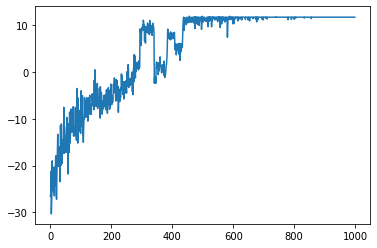

In [8]:
re = []
num_update = 0
data = pd.read_csv("sample_data_20200901_1_train.csv")
train, num_state, midmin, midmax = preprocess(data,True)
ParamSpace = set_space(num_state)

## Initialize Q-table
epsilon = 0.3
alpha, gamma = 0.1, 0.9
Q_table = {}
for d1 in range(num_state):
    for d2 in [-1,0,1]:
        Q_table[d1,d2] = [0 for i in range(3)]

## Main learning algorithm
for ep in range(1000):
    env = TakerGame(train)
    state = env.reset()
    reward = 0
    acts = []
    for i in range(len(train)-1):
        act = chooseAction(state)
        next_state, reward, done = env.step(act)
        acts.append(act)
        q_sa = Q_table[state][act+1]
        maxQ = np.max(Q_table[next_state])
        increment = alpha * (reward + gamma * maxQ - q_sa)
        Q_table[state][act+1] = q_sa + increment
        state_reward = 0
        state = next_state
    cum_reward, pnl = PnLcalculator(acts, env.data.iloc[:, :],show=False)
#     print(ep,cum_reward)
    re.append(cum_reward)
    epsilon *= 0.99
plt.plot(re)

## Test on whole dataset

In [9]:
epsilon = 0
test_data = pd.read_csv("sample_data_20200901_1_train.csv")
test_train,test_num_state, midmin, midmax = preprocess(test_data,False)
env = TakerGame(test_train)
state = env.reset()
reward = 0
acts = []
for i in range(len(test_train)-1):
    act = chooseAction(state)
    next_state, reward, done = env.step(act)
#     print(next_state,act,reward)
    acts.append(act)
    state = next_state
cum_reward, pnl = PnLcalculator(acts, test_train.iloc[:, :],False)
re.append(cum_reward)
print("The overall profit is: $",round(cum_reward,2))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The overall profit is: $ 110.85


# Results:

## Basic mid-price states

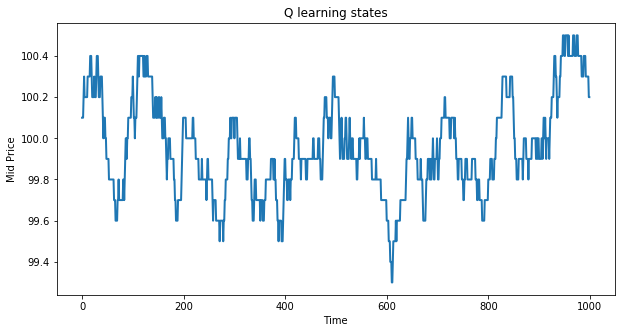

In [10]:
data['mid'] = (data.iloc[:, 1] + data.iloc[:, 2]) / 2
plt.figure(figsize = (10,5))
plt.xlabel("Time")
plt.ylabel("Mid Price")
plt.title("Q learning states")
plt.plot(data['mid'][:1000],linewidth=2)

# Bid and Offer prices

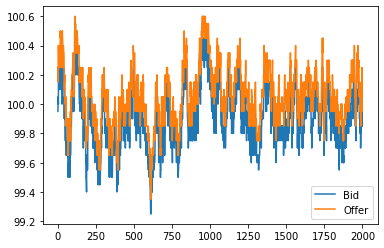

In [11]:
plt.plot(data['bidPrice'][:2000])
plt.plot(data['offerPrice'][:2000])
plt.legend(['Bid','Offer'])
# plt.plot(data['mid'][:2000])

## PnL over the test set

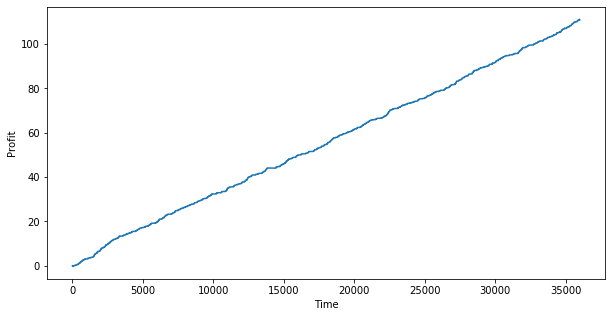

In [12]:
reward, pnl = PnLcalculator(acts, test_train.iloc[:, :],False)
trade_time = test_train.iloc[1:-1,0]
cumpnl = np.array(pnl).cumsum()
plt.figure(figsize=(10, 5))
plt.plot(trade_time,cumpnl)
plt.xlabel("Time")
plt.ylabel("Profit")
plt.show()

# Actions over the time

In [13]:
short, flat, long = [], [], []
short_time, flat_time, long_time = [],[],[]
short_mid, flat_mid,long_mid = [],[],[]
for i in range(1,len(acts)):
    if acts[i] != acts[i-1]:
        if acts[i] == -1:
            short.append(i)
            short_time.append(test_train.iloc[i,0])
            short_mid.append(test_train.iloc[i,3])
        elif acts[i] == 0:
            flat.append(i)
            flat_time.append(test_train.iloc[i,0])
            flat_mid.append(test_train.iloc[i,3])
        else:
            long.append(i)
            long_time.append(test_train.iloc[i,0])
            long_mid.append(test_train.iloc[i,3])

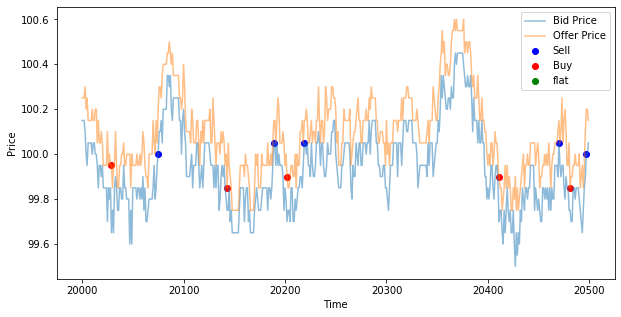

In [20]:
plt.figure(figsize=(10,5))
plt.plot(test_data['bidPrice'][20000:20500],alpha=0.5)
plt.plot(test_data['offerPrice'][20000:20500],alpha=0.5)
plt.scatter(np.array(short_time)[(np.array(short_time)>=20000) & (np.array(short_time)<=20500)], test_data.loc[short_time, 'bidPrice'][20000:20500], c='blue', marker='o', alpha=1)
plt.scatter(np.array(long_time)[(np.array(long_time)>=20000) & (np.array(long_time)<=20500)], test_data.loc[long_time, 'offerPrice'][20000:20500], c='red', marker='o', alpha=1)
plt.scatter(np.array(flat_time)[(np.array(flat_time)>=20000) & (np.array(flat_time)<=20500)], test_data.loc[flat_time, 'bidPrice'][20000:20500], c='green', marker='o', alpha=1)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(['Bid Price','Offer Price','Sell','Buy','flat'])

## Q-table

In [21]:
Q_table

{(0, -1): [0.04278076370027608, -0.4215870713174468, -0.35162175474635077],
 (0, 0): [0.00034648650284448514, 0.0005964030444636742, 0.06916321799328806],
 (0, 1): [0.1627416481566665, 0.018641096694292508, 0.03442322280066926],
 (1, -1): [0.04886345528678062, -0.4272785135392753, -0.2765388383528384],
 (1, 0): [0.0008598853439642815, 0.012587119727665158, 0.1328679710757398],
 (1, 1): [-0.09370740077228543, 0.04779607788631398, 0.0863859894082141],
 (2, -1): [0.06413438136828348, -0.23403171657112234, -0.3054748064307956],
 (2, 0): [0.0005798944180915779, 0.013843871979487572, 0.08002254252471581],
 (2, 1): [-0.04647493764792554, -0.011385866006553492, 0.0967801555889115],
 (3, -1): [0.08333372681423679, -0.1594783106203011, -0.05780547388902946],
 (3, 0): [0.001044778367959995, 0.006004050865584662, 0.0871021295574017],
 (3, 1): [-0.031361383201921805, -0.04776077102613413, 0.12248100792501194],
 (4, -1): [0.10795657344720057, -0.0741259736935916, -0.0033358830832607433],
 (4, 0): [0

## Actions done from the Q-table result

In [22]:
price_bar = np.arange(midmin,midmax,0.1)
long_price = [0]*len(price_bar)
short_price = [0]*len(price_bar)
for i in short_mid:
    short_price[int(round((i-midmin)/0.1))] -= 1
for i in long_mid:
    long_price[int(round((i-midmin)/0.1))] += 1

Text(0, 0.5, 'Frequency')

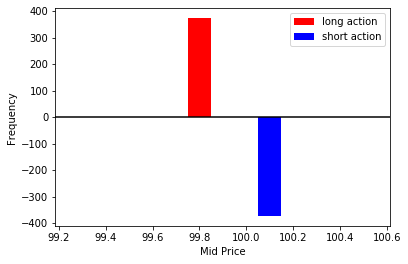

In [23]:
fig = plt.figure()
ax = plt.subplot(111)
ax.bar(price_bar, long_price, width = 0.1,color='r')
ax.bar(price_bar, short_price, width = 0.1,color='b')
plt.legend(['long action','short action'])
plt.axhline(0,color='black')
plt.xlabel("Mid Price")
plt.ylabel("Frequency")